Dataset Shape: (53244, 7)

First 5 rows:
                  date symbol        open       close         low        high  \
0  2016-01-05 00:00:00   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06 00:00:00   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07 00:00:00   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08 00:00:00   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11 00:00:00   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53244 entries, 0 to 53243
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    53244 non-null  object 
 1   symbol  53244 non-null  object 
 2   open    53244 non-null  float64
 3   close   53244 non-null  float64
 4   low     53244 non-null  float64


/tmp/ipython-input-2976339429.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


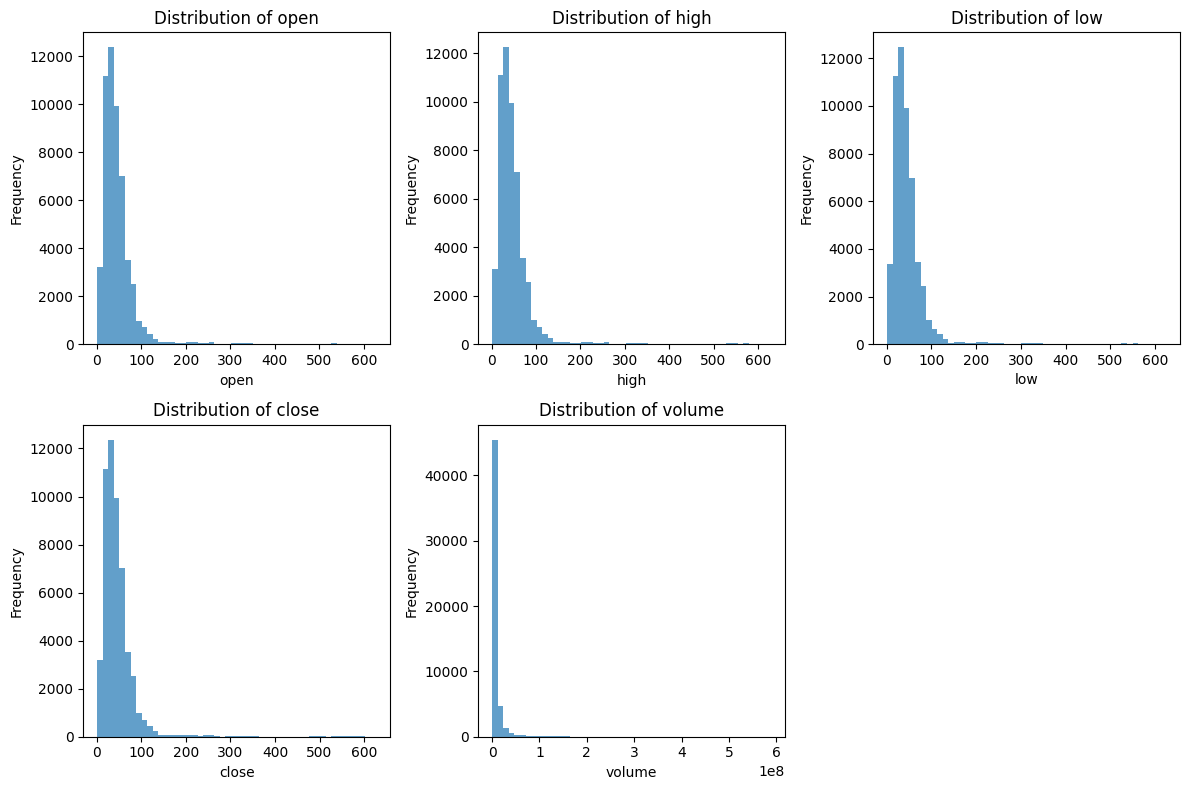

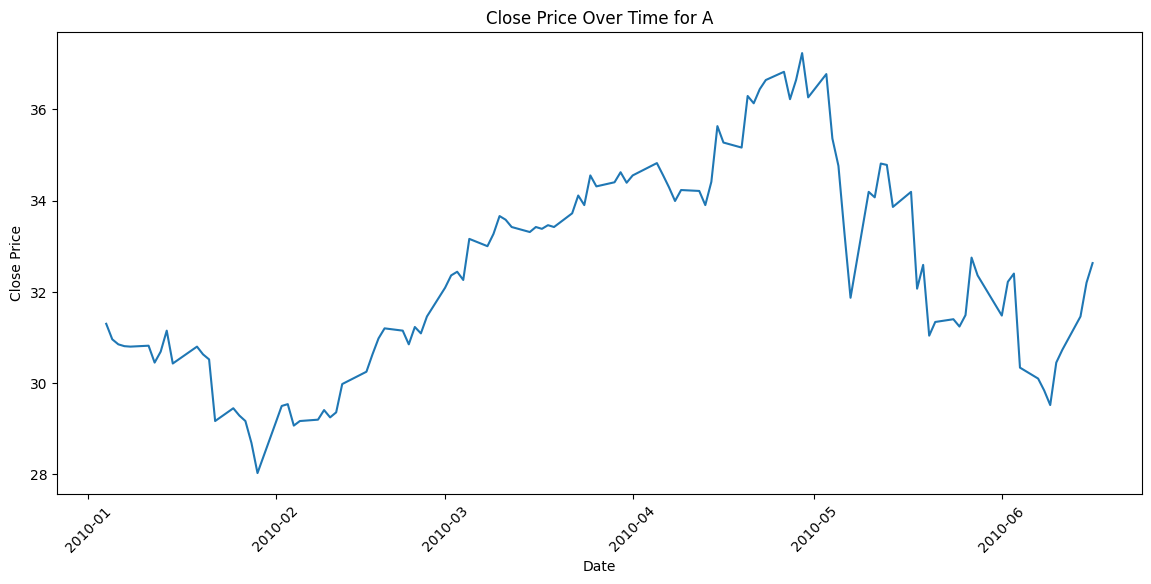

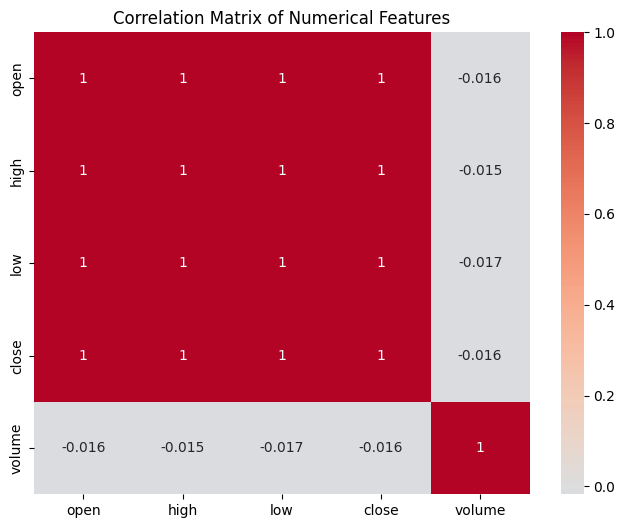

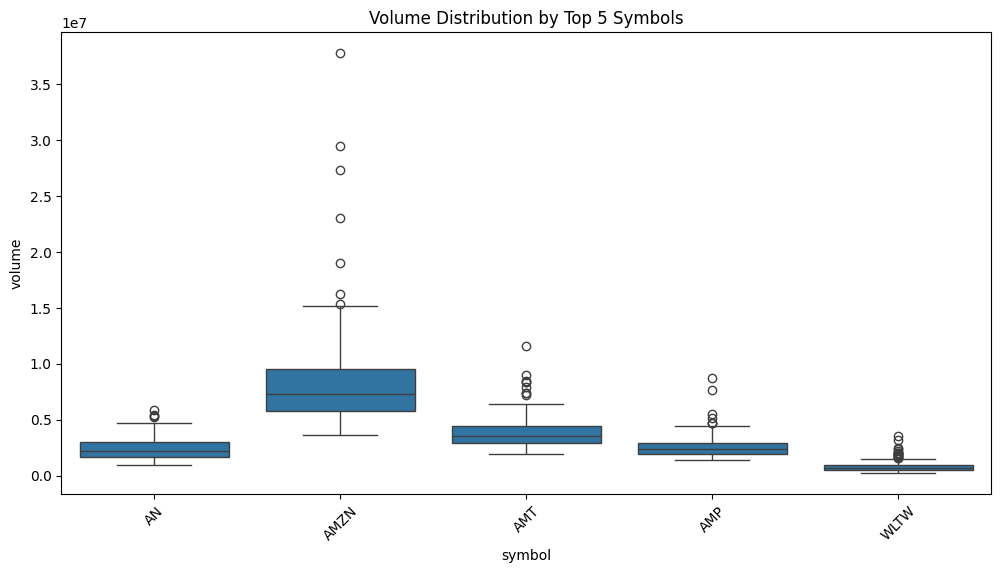


Unique Symbols: 470
Date Range: 2010-01-04 00:00:00 to 2010-06-16 00:00:00


In [ ]:
#Part 1: Exploratory Data Analysis (EDA) to Understand and Visualize the Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

df = pd.read_csv('/content/data-workshop1/prices.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')
df.sort_values('date', inplace=True)  # Sort by date for time-series analysis

print("\nMissing Values per Column:")
print(df.isnull().sum())

df.fillna(method='ffill', inplace=True)


# Visualization 1: Distribution of key numerical features (histograms)
plt.figure(figsize=(12, 8))
numerical_cols = ['open', 'high', 'low', 'close', 'volume']
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    plt.hist(df[col], bins=50, alpha=0.7)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


# Visualization 2: Time-series plot of 'close' price for a sample stock (e.g., first symbol)
sample_symbol = df['symbol'].iloc[0]
sample_df = df[df['symbol'] == sample_symbol]
plt.figure(figsize=(14, 6))
plt.plot(sample_df['date'], sample_df['close'])
plt.title(f'Close Price Over Time for {sample_symbol}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.show()


# Visualization 3: Correlation heatmap (drop 'symbol' and 'date' for numerical corr)
corr_df = df[numerical_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Visualization 4: Boxplot for 'volume' by symbol (sample top 5 symbols to avoid clutter)
top_symbols = df['symbol'].value_counts().head(5).index
sample_volume = df[df['symbol'].isin(top_symbols)]
plt.figure(figsize=(12, 6))
sns.boxplot(data=sample_volume, x='symbol', y='volume')
plt.title('Volume Distribution by Top 5 Symbols')
plt.xticks(rotation=45)
plt.show()

print(f"\nUnique Symbols: {df['symbol'].nunique()}")
print(f"Date Range: {df['date'].min()} to {df['date'].max()}")

In [ ]:

#Part 2: Establish a Deep Neural Network (DNN/MLP) Architecture Using PyTorch for Regression

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Load and prepare data (from Part 1)
df = pd.read_csv('/content/data-workshop1/prices.csv')

df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d',errors='coerce')
# Sample a subset for faster training (e.g., one symbol or 10% data)
df_sample = df.sample(frac=0.1, random_state=42)  # Adjust as needed
features = ['open', 'high', 'low', 'volume']
X = df_sample[features].values
y = df_sample['close'].values.reshape(-1, 1)

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)
X_train = scaler_X.transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.transform(y_train)
y_test = scaler_y.transform(y_test)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define MLP Architecture
class RegressionMLP(nn.Module):
    def __init__(self, input_size=4, hidden_sizes=[64, 32, 16]):
        super(RegressionMLP, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(0.2)  # Basic dropout for regularization
            ])
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, 1))  # Output layer for regression
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Instantiate model
model = RegressionMLP()
print(model)

# Basic training setup (for testing; full training in Part 3)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

# Train loop (simple version)
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')

# Evaluate
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor).item()
print(f'Test MSE: {test_loss:.4f}')

RegressionMLP(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=16, out_features=1, bias=True)
  )
)
Epoch [10/50], Loss: 0.0538
Epoch [20/50], Loss: 0.0554
Epoch [30/50], Loss: 0.0521
Epoch [40/50], Loss: 0.0501
Epoch [50/50], Loss: 0.0513
Test MSE: 0.0090


In [ ]:
# Part 3: Optimized GridSearch for PyTorch

from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class PyTorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_sizes=[64, 32, 16], lr=0.001, epochs=50,
                 optimizer='Adam', batch_size=32):
        self.hidden_sizes = hidden_sizes
        self.lr = lr
        self.epochs = epochs
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.model = None
        self.criterion = nn.MSELoss()

    def fit(self, X, y):
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y.reshape(-1, 1))
        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        self.model = RegressionMLP(input_size=X.shape[1],
                                   hidden_sizes=self.hidden_sizes)

        if self.optimizer == 'Adam':
            opt = optim.Adam(self.model.parameters(), lr=self.lr)
        elif self.optimizer == 'SGD':
            opt = optim.SGD(self.model.parameters(), lr=self.lr)
        else:
            raise ValueError("Unsupported optimizer")

        self.model.train()
        for epoch in range(self.epochs):
            for batch_X, batch_y in loader:
                opt.zero_grad()
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                opt.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X)
            return self.model(X_tensor).cpu().numpy().flatten()

    def score(self, X, y):
        y_pred = self.predict(X)
        return -np.mean((y - y_pred)**2)  # Negative MSE

# OPTIMIZED: Reduced parameter grid
param_grid = {
    'lr': [0.001, 0.01],           # Reduced from 3 to 2
    'optimizer': ['Adam'],          # Only Adam (usually best)
    'epochs': [10, 20],             # Reduced from 3 to 2, removed 5
    'hidden_sizes': [[64, 32, 16]] # Only 1 architecture for speed
}

# This gives 4 combinations instead of 36 (4 × 3 folds = 12 fits)

reg = PyTorchRegressor()

# Set n_jobs=1 for PyTorch (parallel doesn't help)
grid_search = GridSearchCV(
    reg,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,  # More verbose output
    n_jobs=1    # Changed from -1
)

print("Starting GridSearch (this will take a few minutes)...")
grid_search.fit(X_train, y_train.flatten())

# Results
print(f"\nBest Params: {grid_search.best_params_}")
print(f"Best MSE: {-grid_search.best_score_:.4f}")

# Retrain best model with more epochs
best_params = grid_search.best_params_.copy()
best_params['epochs'] = 50  # Train longer for final model

best_model = PyTorchRegressor(**best_params)
best_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = best_model.predict(X_test)
test_mse = np.mean((y_test - y_pred)**2)
print(f"Test MSE: {test_mse:.4f}")

Starting GridSearch (this will take a few minutes)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END epochs=10, hidden_sizes=[64, 32, 16], lr=0.001, optimizer=Adam; total time=  17.3s
[CV] END epochs=10, hidden_sizes=[64, 32, 16], lr=0.001, optimizer=Adam; total time=  14.9s
[CV] END epochs=10, hidden_sizes=[64, 32, 16], lr=0.001, optimizer=Adam; total time=  15.0s
[CV] END epochs=10, hidden_sizes=[64, 32, 16], lr=0.01, optimizer=Adam; total time=  16.0s
[CV] END epochs=10, hidden_sizes=[64, 32, 16], lr=0.01, optimizer=Adam; total time=  14.7s
[CV] END epochs=10, hidden_sizes=[64, 32, 16], lr=0.01, optimizer=Adam; total time=  14.7s
[CV] END epochs=20, hidden_sizes=[64, 32, 16], lr=0.001, optimizer=Adam; total time=  29.6s
[CV] END epochs=20, hidden_sizes=[64, 32, 16], lr=0.001, optimizer=Adam; total time=  29.7s
[CV] END epochs=20, hidden_sizes=[64, 32, 16], lr=0.001, optimizer=Adam; total time=  30.8s
[CV] END epochs=20, hidden_sizes=[64, 32, 16], lr=0.01, optim

Epoch 10: Train Loss=0.0420, Val Loss=0.0305, Train R2=0.9580, Val R2=0.9716
Epoch 20: Train Loss=0.0460, Val Loss=0.0594, Train R2=0.9539, Val R2=0.9447
Epoch 30: Train Loss=0.0395, Val Loss=0.0357, Train R2=0.9604, Val R2=0.9668
Epoch 40: Train Loss=0.0478, Val Loss=0.0446, Train R2=0.9522, Val R2=0.9585
Epoch 50: Train Loss=0.0402, Val Loss=0.0238, Train R2=0.9597, Val R2=0.9778
Unscaled R2 - Train: -0.9760, Val: 0.9778


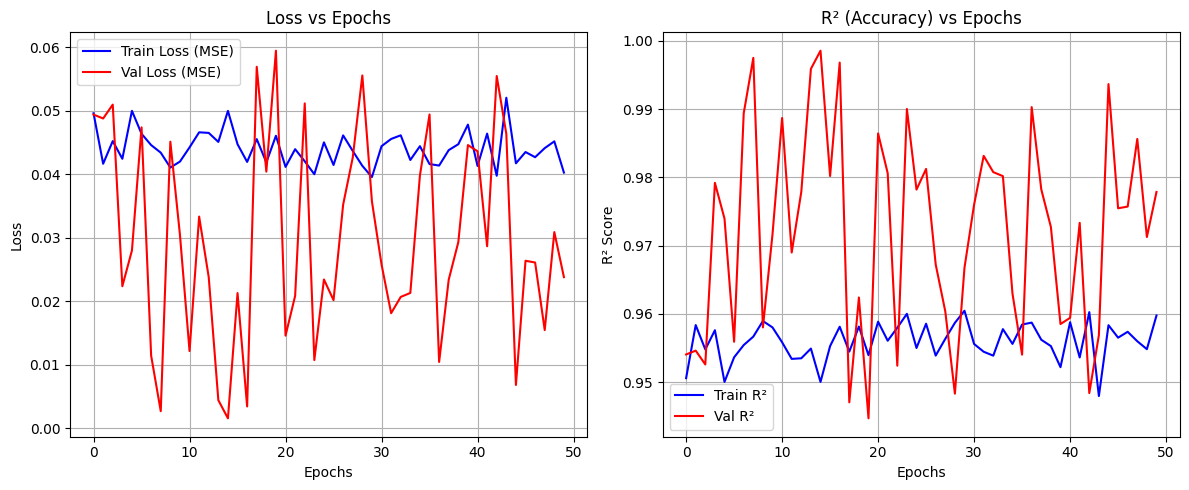

In [ ]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Retrain best model with logging
best_model.model.train()
train_losses, val_losses = [], []
train_r2s, val_r2s = [], []

num_epochs = best_model.epochs
optimizer = optim.Adam(best_model.model.parameters(), lr=best_model.lr) if best_model.optimizer == 'Adam' else optim.SGD(best_model.model.parameters(), lr=best_model.lr)

for epoch in range(num_epochs):
    # Train
    best_model.model.train()
    epoch_train_loss = 0
    train_preds, train_targets = [], []
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = best_model.model(batch_X)
        loss = best_model.criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        train_preds.extend(outputs.detach().numpy())
        train_targets.extend(batch_y.numpy())
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_r2 = r2_score(train_targets, train_preds)
    train_r2s.append(train_r2)

    # Test
    best_model.model.eval()
    epoch_val_loss = 0
    val_preds, val_targets = [], []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = best_model.model(batch_X)
            loss = best_model.criterion(outputs, batch_y)
            epoch_val_loss += loss.item()
            val_preds.extend(outputs.numpy())
            val_targets.extend(batch_y.numpy())
    avg_val_loss = epoch_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    val_r2 = r2_score(val_targets, val_preds)
    val_r2s.append(val_r2)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Train R2={train_r2:.4f}, Val R2={val_r2:.4f}')

# Unscaled R2
train_r2_unscaled = r2_score(scaler_y.inverse_transform(y_train), scaler_y.inverse_transform(np.array(train_preds).reshape(-1,1)))
val_r2_unscaled = r2_score(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(np.array(val_preds).reshape(-1,1)))
print(f'Unscaled R2 - Train: {train_r2_unscaled:.4f}, Val: {val_r2_unscaled:.4f}')

# Plot 1: Loss vs Epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss (MSE)', color='blue')
plt.plot(val_losses, label='Val Loss (MSE)', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)

# Plot 2: R² vs Epochs
plt.subplot(1, 2, 2)
plt.plot(train_r2s, label='Train R²', color='blue')
plt.plot(val_r2s, label='Val R²', color='red')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.title('R² (Accuracy) vs Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Early stopping at epoch 16

Regularization Comparison:
         Model  Val MSE   Val R²
      Baseline 0.023895 0.977850
 Dropout (0.5) 0.014300 0.986745
     L2 (1e-4) 0.003923 0.996364
Early Stopping 0.001042 0.999034


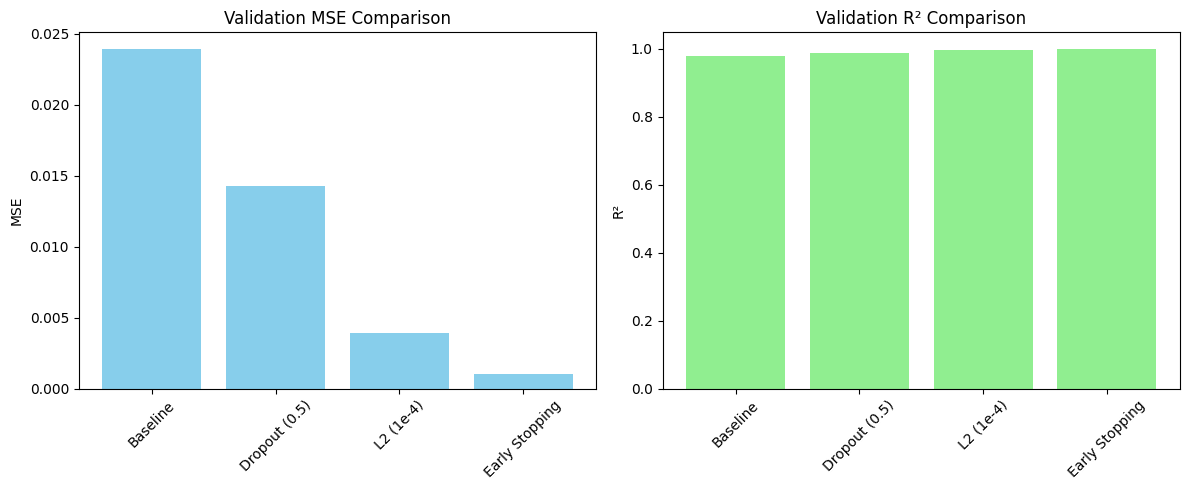


Best regularization technique: Early Stopping
MSE: 0.0010, R²: 0.9990


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Part 4: Regularization Comparison

# Baseline (from Part 3 - best model from GridSearch)
baseline_val_mse = -best_model.score(X_test, y_test.flatten())
baseline_val_r2 = r2_score(y_test, best_model.predict(X_test))

# Variant 1: Higher Dropout (0.5)
class RegDropoutMLP(nn.Module):
    def __init__(self, input_size=4, hidden_sizes=[64, 32, 16], dropout=0.5):
        super().__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Train dropout model
dropout_model_net = RegDropoutMLP(input_size=X_train.shape[1],
                                   hidden_sizes=[64, 32, 16],
                                   dropout=0.5)
dropout_optimizer = optim.Adam(dropout_model_net.parameters(), lr=0.001)
dropout_criterion = nn.MSELoss()

# Prepare data
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train.reshape(-1, 1))
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Train
dropout_model_net.train()
for epoch in range(100):
    for batch_X, batch_y in train_loader:
        dropout_optimizer.zero_grad()
        outputs = dropout_model_net(batch_X)
        loss = dropout_criterion(outputs, batch_y)
        loss.backward()
        dropout_optimizer.step()

# Evaluate
dropout_model_net.eval()
with torch.no_grad():
    dropout_preds = dropout_model_net(torch.FloatTensor(X_test)).numpy().flatten()
dropout_val_mse = np.mean((y_test.flatten() - dropout_preds)**2)
dropout_val_r2 = r2_score(y_test, dropout_preds)

# Variant 2: L2 Regularization (weight_decay)
l2_model_net = RegressionMLP(input_size=X_train.shape[1],
                              hidden_sizes=[64, 32, 16])
l2_optimizer = optim.Adam(l2_model_net.parameters(), lr=0.001, weight_decay=1e-4)
l2_criterion = nn.MSELoss()

# Train
l2_model_net.train()
for epoch in range(100):
    for batch_X, batch_y in train_loader:
        l2_optimizer.zero_grad()
        outputs = l2_model_net(batch_X)
        loss = l2_criterion(outputs, batch_y)
        loss.backward()
        l2_optimizer.step()

# Evaluate
l2_model_net.eval()
with torch.no_grad():
    l2_preds = l2_model_net(torch.FloatTensor(X_test)).numpy().flatten()
l2_val_mse = np.mean((y_test.flatten() - l2_preds)**2)
l2_val_r2 = r2_score(y_test, l2_preds)

# Variant 3: Early Stopping
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

es_model_net = RegressionMLP(input_size=X_train.shape[1],
                              hidden_sizes=[64, 32, 16])
es_optimizer = optim.Adam(es_model_net.parameters(), lr=0.001)
es_criterion = nn.MSELoss()
early_stopping = EarlyStopping(patience=15)

# Prepare validation data
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test.reshape(-1, 1))
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train with early stopping
es_model_net.train()
for epoch in range(100):
    # Training
    for batch_X, batch_y in train_loader:
        es_optimizer.zero_grad()
        outputs = es_model_net(batch_X)
        loss = es_criterion(outputs, batch_y)
        loss.backward()
        es_optimizer.step()

    # Validation
    es_model_net.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = es_model_net(batch_X)
            val_loss += es_criterion(outputs, batch_y).item()
    val_loss /= len(test_loader)

    if early_stopping(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

    es_model_net.train()

# Evaluate
es_model_net.eval()
with torch.no_grad():
    es_preds = es_model_net(torch.FloatTensor(X_test)).numpy().flatten()
es_val_mse = np.mean((y_test.flatten() - es_preds)**2)
es_val_r2 = r2_score(y_test, es_preds)

# Comparison
results = {
    'Model': ['Baseline', 'Dropout (0.5)', 'L2 (1e-4)', 'Early Stopping'],
    'Val MSE': [baseline_val_mse, dropout_val_mse, l2_val_mse, es_val_mse],
    'Val R²': [baseline_val_r2, dropout_val_r2, l2_val_r2, es_val_r2]
}
comparison_df = pd.DataFrame(results)
print("\nRegularization Comparison:")
print(comparison_df.to_string(index=False))

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(results['Model'], results['Val MSE'], color='skyblue')
ax1.set_title('Validation MSE Comparison')
ax1.set_ylabel('MSE')
ax1.tick_params(axis='x', rotation=45)

ax2.bar(results['Model'], results['Val R²'], color='lightgreen')
ax2.set_title('Validation R² Comparison')
ax2.set_ylabel('R²')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Best model
best_idx = np.argmin(results['Val MSE'])
print(f"\nBest regularization technique: {results['Model'][best_idx]}")
print(f"MSE: {results['Val MSE'][best_idx]:.4f}, R²: {results['Val R²'][best_idx]:.4f}")